## AI in Health Technologies
## Course Project: Brain Tumor Segmentation
Tuomas Laiho
Jesse Viljanen
Elsa Ollikainen


## Importing packages and libraries:

In [1]:
!pip install nilearn
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1c604c78a59face7b9597af76a1c089c6f37252b2b69166694525254fae57d74
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4a51c15c05d51c60d8c46b31e9e56f41847f5918afb9c14755156b662307b61a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pyt

In [2]:
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import matplotlib.pyplot as plt
from skimage.transform import rotate
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize, to_categorical
import tarfile
import os
import segmentation_models_pytorch as smp
from sklearn.preprocessing import MinMaxScaler
import random
import glob
import splitfolders
import torch
import pytorch_lightning as pl
from pprint import pprint
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

## Connecting to drive folders and loading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/COLAB/data
!ls

/content/drive/MyDrive/COLAB/data
BraTS2021_00495.tar  BraTS2021_00621.tar  BraTS2021_TrainingData  extracted_data  Logfiles  models


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dschettler8845/brats-2021-task1
!unzip brats-2021-task1.zip -d data/ > /dev/null

In [ ]:
# Replace 'your_tar_file.tar.gz' with the actual name of your tar file
tar_file_path = 'BraTS2021_Training_Data.tar'

# Specify the directory where you want to extract the contents of the tar file
extract_path = 'extracted_data'

# Create the target directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Open the tar file
with tarfile.open(tar_file_path, 'r:') as tar:
    # Extract all contents to the specified directory
    tar.extractall(path=extract_path)

# List the contents of the extracted directory
extracted_files = os.listdir(extract_path)
print("Contents of the extracted directory:", extracted_files)


Contents of the extracted directory: ['.DS_Store', 'BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005', 'BraTS2021_00006', 'BraTS2021_00008', 'BraTS2021_00009', 'BraTS2021_00011', 'BraTS2021_00012', 'BraTS2021_00014', 'BraTS2021_00016', 'BraTS2021_00017', 'BraTS2021_00018', 'BraTS2021_00019', 'BraTS2021_00020', 'BraTS2021_00021', 'BraTS2021_00022', 'BraTS2021_00024', 'BraTS2021_00025', 'BraTS2021_00026', 'BraTS2021_00028', 'BraTS2021_00030', 'BraTS2021_00031', 'BraTS2021_00032', 'BraTS2021_00033', 'BraTS2021_00035', 'BraTS2021_00036', 'BraTS2021_00043', 'BraTS2021_00044', 'BraTS2021_00045', 'BraTS2021_00046', 'BraTS2021_00048', 'BraTS2021_00049', 'BraTS2021_00051', 'BraTS2021_00052', 'BraTS2021_00053', 'BraTS2021_00054', 'BraTS2021_00056', 'BraTS2021_00058', 'BraTS2021_00059', 'BraTS2021_00060', 'BraTS2021_00061', 'BraTS2021_00062', 'BraTS2021_00063', 'BraTS2021_00064', 'BraTS2021_00066', 'BraTS2021_00068', 'BraTS2021_00070', 'BraTS2021_00071', 'BraTS2021_00072',

## Loading testing image and visualizing the data:

In [ ]:
train_path = 'extracted_data/BraTS2021_00000/'
test_image_t1=nib.load(train_path + 'BraTS2021_00000_t1.nii.gz').get_fdata()
test_image_flair=nib.load(train_path + 'BraTS2021_00000_flair.nii.gz').get_fdata()
test_image_t1ce=nib.load(train_path + 'BraTS2021_00000_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(train_path + 'BraTS2021_00000_t2.nii.gz').get_fdata()
test_mask=nib.load(train_path + 'BraTS2021_00000_seg.nii.gz').get_fdata()

Text(0.5, 1.0, 'Mask')

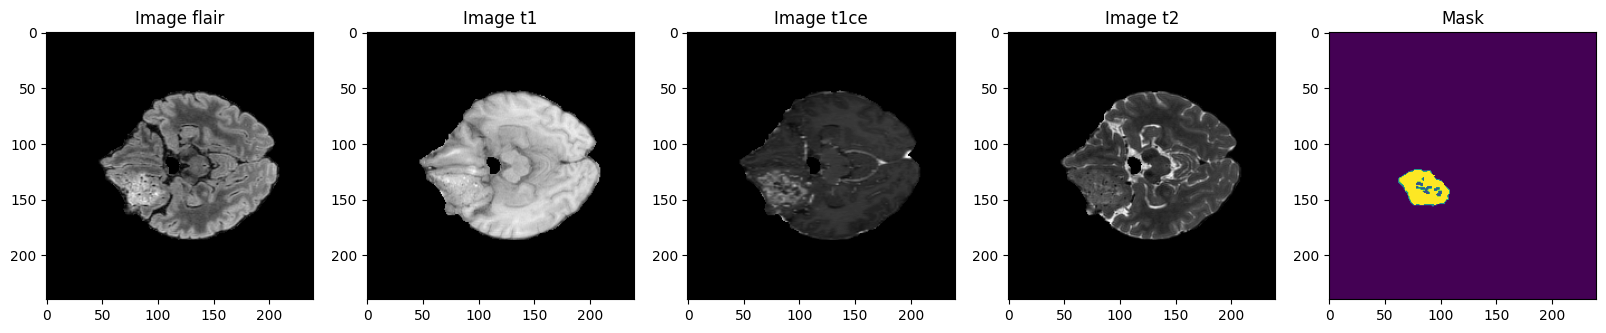

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 64
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [ ]:
scaler = MinMaxScaler()

test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


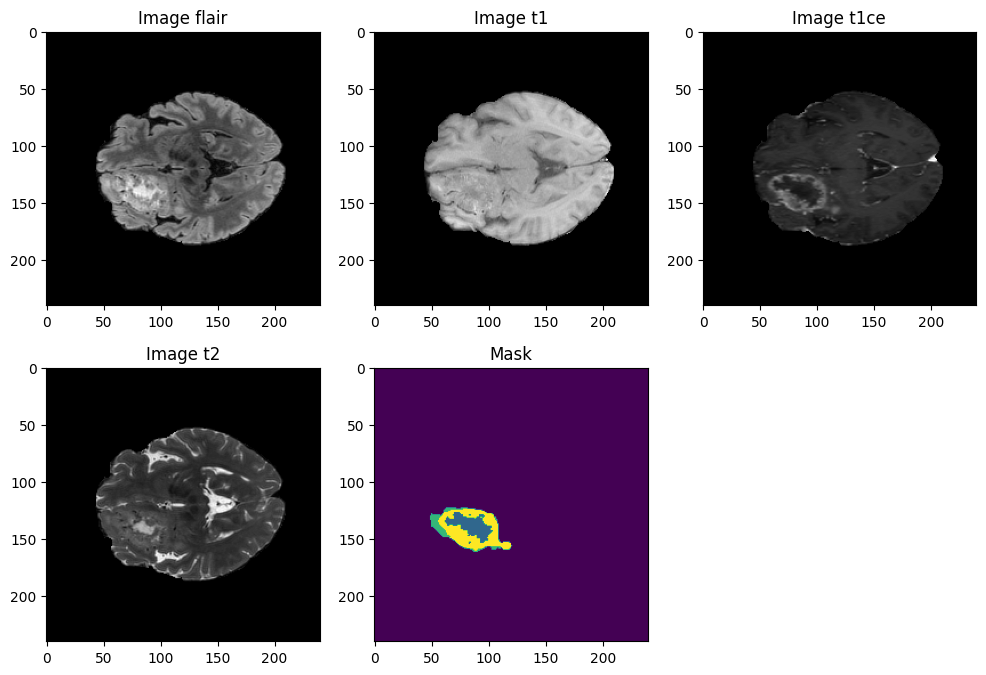

In [ ]:
#Plotting random slices

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))
n_slice =64
plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Combining the weighted T1 and T2 images and the FLAIR T2 image into a single-channel one and cropping the space without useful information so that the images are sized 128x128:

In [ ]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis = 3)
combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4
test_mask = test_mask[56:184, 56:184, 13:141]

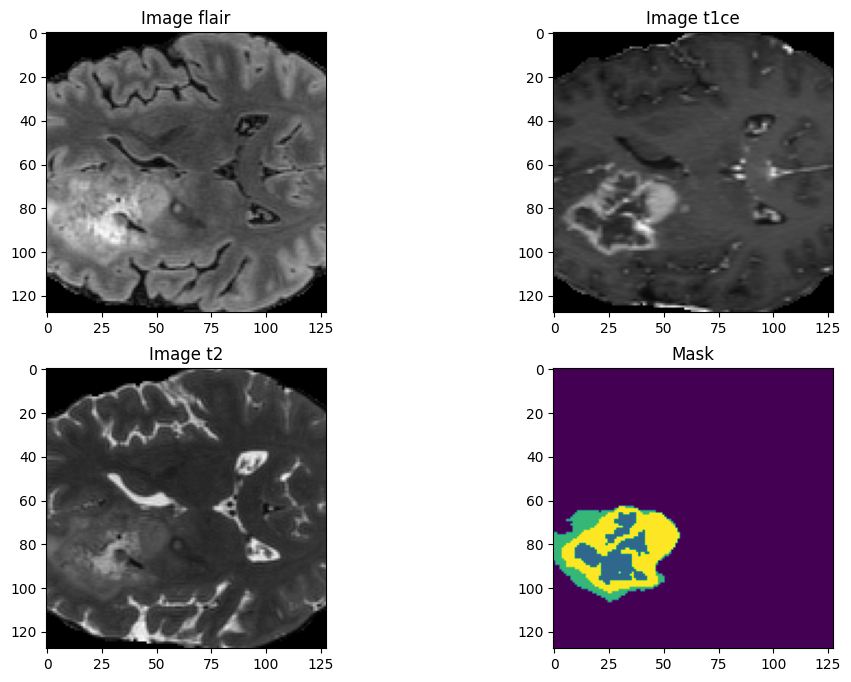

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

The data looks good so let's apply the processing to all of the data files. After processing the data files are converted to numpy arrays.

In [ ]:
os.makedirs('BraTS2021_TrainingData', exist_ok = True)

In [ ]:
t2_list = sorted(glob.glob('extracted_data/*/*t2.nii.gz'))
t1ce_list = sorted(glob.glob('extracted_data/*/*t1ce.nii.gz'))
flair_list = sorted(glob.glob('extracted_data/*/*flair.nii.gz'))
mask_list = sorted(glob.glob('extracted_data/*/*seg.nii.gz'))

In [ ]:
print(len(t2_list))
print(len(mask_list))

1251
1251


In [ ]:
#Use lesser amount of data

t2_list_100 = t2_list[:100]
t1ce_list_100 = t1ce_list[:100]
flair_list_100 = flair_list[0:100]
mask_list_100 = mask_list[0:100]

In [ ]:
#Make directories for data
os.makedirs('BraTS2021_TrainingData/input_data_3channels/images', exist_ok = True)
os.makedirs('BraTS2021_TrainingData/input_data_3channels/masks', exist_ok = True)

In [ ]:
for img in range(len(t2_list_100)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2_list_100[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce_list_100[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair_list_100[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask_list_100[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    temp_mask= to_categorical(temp_mask, num_classes=4)
    np.save('BraTS2021_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
    np.save('BraTS2021_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)

Now preparing image and masks number:  0
Now preparing image and masks number:  1
Now preparing image and masks number:  2
Now preparing image and masks number:  3
Now preparing image and masks number:  4
Now preparing image and masks number:  5
Now preparing image and masks number:  6
Now preparing image and masks number:  7
Now preparing image and masks number:  8
Now preparing image and masks number:  9
Now preparing image and masks number:  10
Now preparing image and masks number:  11
Now preparing image and masks number:  12
Now preparing image and masks number:  13
Now preparing image and masks number:  14
Now preparing image and masks number:  15
Now preparing image and masks number:  16
Now preparing image and masks number:  17
Now preparing image and masks number:  18
Now preparing image and masks number:  19
Now preparing image and masks number:  20
Now preparing image and masks number:  21
Now preparing image and masks number:  22
Now preparing image and masks number:  23
No

In [ ]:
# Splitting the data into training and validation:
input_folder = 'BraTS2021_TrainingData/input_data_3channels/'
output_folder = 'BraTS2021_TrainingData/input_data_128/'
# Split with a ratio.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.80, .2), group_prefix=None)

Copying files: 200 files [02:14,  1.49 files/s]


In [ ]:
# Checking that the data is in the correct shape:
image = np.load('BraTS2021_TrainingData/input_data_128/train/images/image_0.npy')
mask  = np.load('BraTS2021_TrainingData/input_data_128/train/masks/mask_0.npy')
print(image.shape)
print(mask.shape)

(128, 128, 128, 3)
(128, 128, 128, 4)


## Converting the data into PyTorch dataset and creating a custom data loader:

In [5]:
class BratsDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)  # List of image files
        self.transform = transform

    def __len__(self):
        return len(self.images) * 128  # Assuming 128 slices per image

    def __getitem__(self, idx):
        img_idx = idx // 128  # Determine which image
        slice_idx = idx % 128  # Determine which slice of the image

        img_name = self.images[img_idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = 'mask_' + img_name.split('_')[1]
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.load(img_path)
        mask = np.load(mask_path)

        # Selecting a 2D slice
        image_slice = image[:, :, slice_idx]
        mask_slice = mask[:, :, slice_idx]

        # Ensure image_slice is in [C, H, W] format
        if image_slice.ndim == 2:
            image_slice = np.expand_dims(image_slice, axis=0)  # Add channel dimension

        # Apply transformations
        if self.transform:
            image_slice = self.transform(image_slice)
            mask_slice = self.transform(mask_slice)

        return image_slice, mask_slice


In [6]:
image_dir = 'BraTS2021_TrainingData/input_data_128/train/images'
mask_dir = 'BraTS2021_TrainingData/input_data_128/train/masks'
image_dir_val = 'BraTS2021_TrainingData/input_data_128/val/images'
mask_dir_val = 'BraTS2021_TrainingData/input_data_128/val/masks'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # Ensure tensor is converted to float
])

brats_dataset = BratsDataset(image_dir, mask_dir, transform=transform)
brats_dataset_val = BratsDataset(image_dir_val, mask_dir_val, transform=transform)

In [7]:
num_samples_for_testing = 512
indices = list(range(num_samples_for_testing))
subset_dataset = Subset(brats_dataset, indices)

num_samples_for_val = 200
indices_val = list(range(num_samples_for_val))
subset_dataset_val = Subset(brats_dataset_val, indices_val)

In [8]:
test_loader = DataLoader(subset_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(subset_dataset_val, batch_size=64, shuffle=False)

## Defining the baseline model and training:

In [9]:
model = smp.Unet(
    encoder_name="resnet18",        # Choose encoder
    encoder_weights="imagenet",     # Pre-trained weights
    in_channels=3,                  # Match the number of channels in your images
    classes=4,                      # Match the number of classes in your masks
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.6MB/s]


In [ ]:
# Training loop:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss_history = []
num_epochs = 20

val_loss_history = []

criterion = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()  # Setting the model to training mode
    epoch_losses = []

    for images, labels in test_loader:

        outputs = model(images)

        # Computing loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    # Computing the average loss for this epoch
    epoch_loss = np.mean(epoch_losses)
    train_loss_history.append(epoch_loss)

    model.eval()

    epoch_val_losses = []

    with torch.no_grad():
      for val_images, val_labels in val_loader:

          val_outputs = model(val_images)

          # Computing validation loss
          val_loss = criterion(val_outputs, val_labels)
          epoch_val_losses.append(val_loss.item())

    # Compute average validation loss for this epoch
    val_loss = np.mean(epoch_val_losses)
    val_loss_history.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")


Epoch [1/20], Loss: 0.8705
Epoch [2/20], Loss: 0.7668
Epoch [3/20], Loss: 0.6825
Epoch [4/20], Loss: 0.6090
Epoch [5/20], Loss: 0.5477
Epoch [6/20], Loss: 0.4963
Epoch [7/20], Loss: 0.4527
Epoch [8/20], Loss: 0.4156
Epoch [9/20], Loss: 0.3828
Epoch [10/20], Loss: 0.3542
Epoch [11/20], Loss: 0.3302
Epoch [12/20], Loss: 0.3089
Epoch [13/20], Loss: 0.2865
Epoch [14/20], Loss: 0.2663
Epoch [15/20], Loss: 0.2489
Epoch [16/20], Loss: 0.2339
Epoch [17/20], Loss: 0.2213
Epoch [18/20], Loss: 0.2103
Epoch [19/20], Loss: 0.1991
Epoch [20/20], Loss: 0.1909


In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Saving the weights of the baseline model:

In [ ]:
os.makedirs('models', exist_ok = True)
torch.save(model.state_dict(), 'models/model1_weights.pth')

## Checking the results:

In [ ]:
model.load_state_dict(torch.load('models/model1_weights.pth'))
model.eval()  # Setting the model to evaluation mode

with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images)
        mask1 = masks
        image = images

        break

print(mask1.shape)
print(outputs.shape)
print(image.shape)

torch.Size([64, 4, 128, 128])
torch.Size([64, 4, 128, 128])
torch.Size([64, 3, 128, 128])


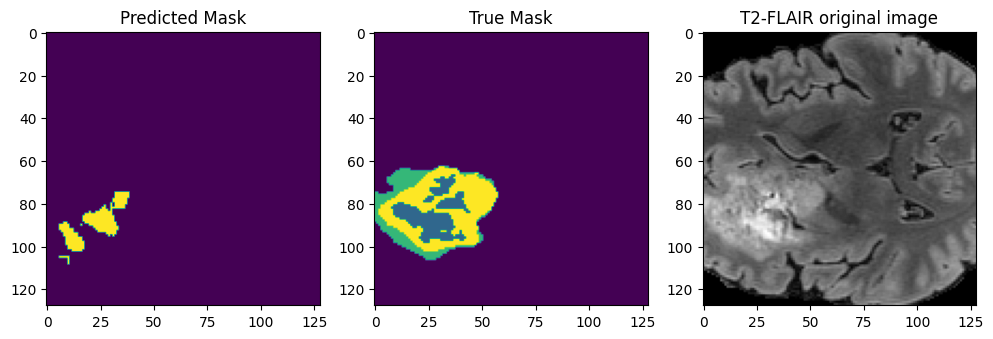

In [ ]:
predicted_mask = outputs[63]
predicted_mask = np.argmax(predicted_mask, axis=0)

truemask = mask1[63]
truemask = np.argmax(truemask, axis=0)

trueimage = image[63]

# Converting to NumPy array
numpy_image = trueimage[0,:,:].numpy()

# Creating a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Plotting the predicted mask
axs[0].imshow(predicted_mask, cmap='viridis')
axs[0].set_title('Predicted Mask')

# Plotting the ground truth mask
axs[1].imshow(truemask, cmap='viridis')
axs[1].set_title('True Mask')

axs[2].imshow(numpy_image, cmap='gray')
axs[2].set_title('T2-FLAIR original image')

plt.show()

## Defining a model with a more powerful backbone:

In [10]:
better_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=4,
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 123MB/s]


In [ ]:
optimizer = torch.optim.Adam(better_model.parameters(), lr=1e-4)

train_loss_history = []
num_epochs = 30

val_loss_history = []

criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    better_model.train()  # Set the model to training mode
    epoch_losses = []

    for images, labels in test_loader:

        outputs = better_model(images)

        # Computing loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    # Computing the average loss for this epoch
    epoch_loss = np.mean(epoch_losses)
    train_loss_history.append(epoch_loss)

    better_model.eval()

    epoch_val_losses = []

    with torch.no_grad():
      for val_images, val_labels in val_loader:

          val_outputs = better_model(val_images)

          # Computing validation loss
          val_loss = criterion(val_outputs, val_labels)
          epoch_val_losses.append(val_loss.item())

    # Computing average validation loss for this epoch
    val_loss = np.mean(epoch_val_losses)
    val_loss_history.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training loss: {epoch_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

Epoch [1/30], Validation Loss: 1.1971
Epoch [1/30], Loss: 1.1556
Epoch [2/30], Validation Loss: 1.0087
Epoch [2/30], Loss: 0.9790
Epoch [3/30], Validation Loss: 0.8417
Epoch [3/30], Loss: 0.8485
Epoch [4/30], Validation Loss: 0.7407
Epoch [4/30], Loss: 0.7548
Epoch [5/30], Validation Loss: 0.6628
Epoch [5/30], Loss: 0.6806
Epoch [6/30], Validation Loss: 0.6034
Epoch [6/30], Loss: 0.6194
Epoch [7/30], Validation Loss: 0.5594
Epoch [7/30], Loss: 0.5679
Epoch [8/30], Validation Loss: 0.5259
Epoch [8/30], Loss: 0.5253
Epoch [9/30], Validation Loss: 0.4957
Epoch [9/30], Loss: 0.4890
Epoch [10/30], Validation Loss: 0.4791
Epoch [10/30], Loss: 0.4559
Epoch [11/30], Validation Loss: 0.4467
Epoch [11/30], Loss: 0.4261
Epoch [12/30], Validation Loss: 0.4319
Epoch [12/30], Loss: 0.3969
Epoch [13/30], Validation Loss: 0.4056
Epoch [13/30], Loss: 0.3716
Epoch [14/30], Validation Loss: 0.3988
Epoch [14/30], Loss: 0.3500
Epoch [15/30], Validation Loss: 0.3714
Epoch [15/30], Loss: 0.3307
Epoch [16/30]

Saving the enhanced model weights:

In [ ]:
torch.save(better_model.state_dict(), 'models/better_model_weights.pth')

Plotting the losses:

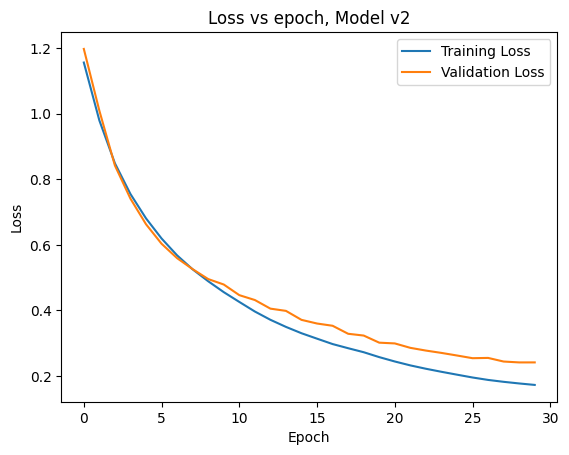

In [ ]:
plt.title("Loss vs epoch, Model v2")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(train_loss_history)
plt.plot(val_loss_history)

plt.legend(["Training Loss", "Validation Loss"])
plt.show()

Checking the results with the more powerful model:

In [ ]:
better_model.load_state_dict(torch.load('models/better_model_final_weights.pth'))
better_model.eval()  # Setting the model to evaluation mode

with torch.no_grad():
    for images, masks in test_loader:
        outputs = better_model(images)
        mask1 = masks
        image = images

        break

print(mask1.shape)
print(outputs.shape)
print(image.shape)

In [ ]:
predicted_mask = outputs[63]
predicted_mask = np.argmax(predicted_mask, axis=0)

truemask = mask1[63]
truemask = np.argmax(truemask, axis=0)

trueimage = image[63]

# Converting to NumPy array
numpy_image = trueimage[0,:,:].numpy()

# Creating a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Plotting the predicted mask
axs[0].imshow(predicted_mask, cmap='viridis')
axs[0].set_title('Predicted Mask')

# Plotting the ground truth mask
axs[1].imshow(truemask, cmap='viridis')
axs[1].set_title('True Mask')

axs[2].imshow(numpy_image, cmap='gray')
axs[2].set_title('T2-FLAIR original image')

plt.show()

## Evaluating the model performances with hausdorf distance, mean average surface distance and jaccard index:

In [11]:
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt
from skimage import measure
from sklearn.metrics import jaccard_score


''' Functions for calculating the metrics'''

def hausdorff_distance(mask1, mask2):

    # Transferring data into correct form:
    mask1 = np.argmax(mask1, axis=1)
    mask2 = np.argmax(mask2, axis=1)

    # Find coordinates of non-zero pixels in the masks
    coords_mask1 = np.array(np.where(mask1)).T
    coords_mask2 = np.array(np.where(mask2)).T

    # Calculate directed Hausdorff distance from mask1 to mask2
    hausdorff_distance_A_to_B = directed_hausdorff(coords_mask1, coords_mask2)[0]

    # Calculate directed Hausdorff distance from mask2 to mask1
    hausdorff_distance_B_to_A = directed_hausdorff(coords_mask2, coords_mask1)[0]

    # Calculate undirected Hausdorff distance
    hausdorff_distance = max(hausdorff_distance_A_to_B, hausdorff_distance_B_to_A)

    return hausdorff_distance


def mean_average_surface_distance(mask1, mask2):

    # Transferring data into correct form:
    mask1 = np.argmax(mask1, axis=1)
    mask2 = np.argmax(mask2, axis=1)

    mask1_np = mask1.cpu().numpy()
    mask2_np = mask2.cpu().numpy()

    # Calculating distance transform for each mask
    dist_transform_mask1 = distance_transform_edt(mask1_np)
    dist_transform_mask2 = distance_transform_edt(mask2_np)

    # Finding coordinates of non-zero pixels in the masks
    coords_mask1 = np.array(np.where(mask1_np)).T
    coords_mask2 = np.array(np.where(mask2_np)).T

    # Calculating average surface distance from mask1 to mask2
    asd_A_to_B = np.mean([dist_transform_mask2[tuple(coord)] for coord in coords_mask1])

    # Calculating average surface distance from mask2 to mask1
    asd_B_to_A = np.mean([dist_transform_mask1[tuple(coord)] for coord in coords_mask2])

    # Calculating mean average surface distance
    mean_asd = 0.5 * (asd_A_to_B + asd_B_to_A)

    return mean_asd

def jaccard_index(mask1, mask2):

    mask1 = np.argmax(mask1, axis=1)
    mask2 = np.argmax(mask2, axis=1)

    mask1_np = mask1.cpu().numpy()
    mask2_np = mask2.cpu().numpy()

    flat_image1 = mask1_np.flatten()
    flat_image2 = mask2_np.flatten()

    return jaccard_score(flat_image1, flat_image2, average='weighted')

In [12]:
# Computing hausdorf distance, mean average surface distance and jaccard index for the baseline model:

def computing_metrics(model):

  model.eval()  # Set the model to evaluation mode

  hausdorf_dist = []
  mean_asd = []
  jaccard_idx = []

  with torch.no_grad():
        for val_images, val_labels in val_loader:
          predicted_mask = model(val_images)
          true_label = val_labels

          hausdorf_dist.append(hausdorff_distance(true_label, predicted_mask))
          mean_asd.append(mean_average_surface_distance(true_label, predicted_mask))
          jaccard_idx.append(jaccard_index(true_label, predicted_mask))


  mean_hd = np.mean(hausdorf_dist)
  print("Average Hausdorf distance:", mean_hd)
  mean_asd2 = np.mean(mean_asd)
  print("Average of mean average surface distance values:", mean_asd2)
  mean_jaccard = np.mean(jaccard_idx)
  print("Average jaccard index:", mean_jaccard)

In [13]:
model.load_state_dict(torch.load('models/model1_weights.pth'))
better_model.load_state_dict(torch.load('models/better_model_final_weights.pth'))

computing_metrics(model)
computing_metrics(better_model)

Average Hausdorf distance: 46.61389863742461
Average of mean average surface distance values: 3.5286460276725284
Average jaccard index: 0.9154635001061262
Average Hausdorf distance: 26.635226419803143
Average of mean average surface distance values: 3.906993662679022
Average jaccard index: 0.9035716904636881


## Comparing the enhanced model to the baseline model with bootstrapping:

In [14]:
# Bootstrap testing
from sklearn.utils import resample

def bootstrap_test(model1, model2, dataset, num_iterations=20):
    jaccard_scores_model1 = []
    jaccard_scores_model2 = []

    for _ in range(num_iterations):
        # Resampling the dataset (not the DataLoader)
        resampled_data = resample(dataset, replace=True)

        # Creating a new DataLoader with the resampled data
        resampled_loader = DataLoader(resampled_data, batch_size=64)

        jaccard_idx1 = []
        jaccard_idx2 = []

        # Evaluate both models
        with torch.no_grad():
          for val_images, val_labels in resampled_loader:
            predicted_mask1 = model1(val_images)
            true_label = val_labels
            predicted_mask2 = model2(val_images)

            jaccard_idx1.append(jaccard_index(true_label, predicted_mask1))
            jaccard_idx2.append(jaccard_index(true_label, predicted_mask2))

        jaccard_model1 = np.mean(jaccard_idx1)
        jaccard_model2 = np.mean(jaccard_idx2)

        # Store the Kappa scores
        jaccard_scores_model1.append(jaccard_model1)
        jaccard_scores_model2.append(jaccard_model2)

    return jaccard_scores_model1, jaccard_scores_model2

In [15]:
jaccard_model1, jaccard_model2 = bootstrap_test(model, better_model, subset_dataset_val)
print(jaccard_model1)
print(jaccard_model2)

[0.9532757549689461, 0.9580261961384854, 0.9498192052046623, 0.9567230812681252, 0.9602017090257544, 0.948898598198498, 0.9497646593146003, 0.9483799071684774, 0.9484584176904189, 0.9409523387796487, 0.9492247829462818, 0.9642649222937592, 0.9414135294277177, 0.9500118528179258, 0.9456931230706229, 0.9541034383034748, 0.9502301861887431, 0.9465664633575113, 0.9558658061680261, 0.9481745818444567]
[0.9379469060189201, 0.9400920258258425, 0.9269655644107649, 0.941316330671191, 0.9400366159445024, 0.9283178307403929, 0.9254239172616303, 0.9354513761860574, 0.9341486802742254, 0.9149743311705487, 0.9196287919694521, 0.9542469897045084, 0.9235293432771321, 0.930005759699121, 0.9231445246233205, 0.9421355618033338, 0.9303379793751607, 0.9279595451317464, 0.9437734428411999, 0.9377965481507856]


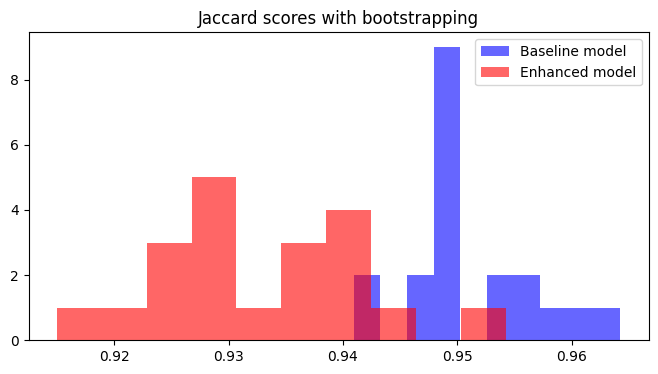

In [16]:

plt.figure(figsize=(8, 4))

plt.hist(jaccard_model1, bins=10, alpha=0.6, label='Baseline model', color='b')
plt.hist(jaccard_model2, bins=10, alpha=0.6, label='Enhanced model', color='r')
plt.title('Jaccard scores with bootstrapping')
plt.legend()
plt.show()